# Introduction

## Introduction1.为什么要控制文本情绪（和政策行动）
成功的政策沟通应该利用多种渠道引导公众朝着预期的方向前进。为了避免不和谐和混淆，语言和非语言信息应该是一致的，相互加强。然而，如果政策沟通是一种协同的努力，人们怎么能听到货币政策的声音 (语气)? 在政策信息传达给公众的方式缺乏外生变化的情况下，识别语音语调的影响必须依赖于控制政策信息的文本情绪以及政策行动。为此，我们采用最先进的自然语言处理 (NLP) 工具来量化 FOMC 文本的情绪

简单来说，文本情绪和语音情绪的信息是共同作用的，如果想要观察语音情绪的作用结果，那么我们必须把文本情绪剥离出来

## Introduction 2. 数据
### 2.1 预测数据
从 2011 年 4 月到 2019 年 6 月，因为 2011 年 4 月开始新闻发布会开始举办，总共有 68 场会议（Statement）和
36 场新闻发布会（Q&A和Remarks）。
### 2.2 模型训练数据
• 联邦公开市场委员会 1997 年到 2010 年之间所有的声明以及这些声明的所有单个语句

• 标签（有监督学习）：每条文本分别被几个研究助手打分，分数从-10（十分鹰派）到 +10（十分鸽派），平均分大于等于 0.5 分的文本被认为是鸽派，小于等于-0.5 被认为是鹰派，中间剩余的被认为是中立的
### 2.3 文本数据来源和处理
• 每次会议，联邦公开市场委员会的声明和新闻发布会的文字记录都可以从美联储 (Fed) 网站上获得

https://www.federalreserve.gov/monetarypolicy/fomc_historical.htm

• ”FOMC_transcripts.zip” 包含了在 2011 年到 2019 年 6 月期间的所有联邦公开市场委员会（FOMC）会议记录的文件，这些记录以 pdf 格式存储。这些会议记录已经被转换成 txt 格式，并经过手动分割，分为开场发言、问题和回答三个部分, 分类结果放在 FED_text.xlsx 中

• 为了衡量总体情绪，我们预测了声明、公开演讲/评论、和 Q&A 环节的回答三种来源的文本情绪（statement/remarks/answers）


## Introduction 3.模型构建部分
本文的模型主要可以分为 BERT 模型和神经网络模型两大部分，神经网络模型利用 BERT 模型的输出作为输入。

### 3.0 文本分词和编码（输入数据）

### 3.1 BERT部分
BERT 通过预训练学习词汇的上下文相关性，生成每个单词的高维度表示。这些表示被称为嵌入（embeddings），其中每个单词都由一个包含其上下文信息的向量表示

#### 3.1.1 why BERT
1. 与无上下文模型（例如 Word2Vec、GloVE）不同，BERT 生成基于单词周围上下文的嵌入表示，即上下文相关的表示。
2.  其次，相对于单向上下文模型（例如 ELMo、ULMFit），BERT 是一个双向模型，考虑了单
词前后的上下文来生成单词的嵌入。

### 3.2神经网络模型部分

#### 3.2.1 神经网络的结构 

输入层： 输入层接收的是BERT嵌入模型的最后一层的输出，这个输出的维度是512×768。

第一个隐藏层： 使用长短时记忆（LSTM）的一种特殊形式，即双向LSTM层。LSTM层有512个单元，通过双曲正切激活函数与输入层相连接。

第二层： 双向LSTM层的输出经过全局平均池化层，将其转换为一维数据。

第三层： 一个密集层，有512个节点。

第四层： 另一个密集层，有128个节点。

Dropout层： 在第一、第二和第三个隐藏层后添加了一个丢弃层，其目的是以10%的概率随机忽略某些神经元，以防止过拟合。

输出层： 输出层有三个节点，代表三个情感类别：鹰派、中性和鸽派。使用softmax激活函数将输出层连接到第三个隐藏层。

# 代码部分

### 0.加载包

In [1]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random as python_random

下面主要介绍相关的transformers、tensorflow和scikit-learn库

##### transformers

transformers是Hugging Face开发的库，用于处理自然语言处理（NLP）中的预训练模型。该库的主要目的是提供广泛使用的预训练语言模型（如BERT、GPT、RoBERTa等）的实现，以便研究人员和从业者可以轻松使用这些强大的模型进行各种NLP任务。在这里，它被用来加载BERT模型和其对应的tokenizer

Tokenizer可以将文本分割成词汇单元，并将其映射为模型所需的输入编码。使用 tokenizer 的好处之一是，它简化了文本编码的过程，用户无需手动构建词汇表或进行文本编码。tokenizer 已经封装了这些细节，使得用户可以更方便地将文本数据转换为模型可接受的形式。

其具体工作流程如下：

1. 文本分词： tokenizer 将输入的文本分割成词汇单元（token）。这可以包括词语、子词或字符，具体取决于使用的 tokenizer 和模型。

2. 词汇编码： tokenizer 将每个词汇单元映射到词汇表中的相应整数ID。这个映射是根据预训练模型学到的词汇表完成的，包含了在预训练时学到的语言知识。（与训练是模型发布之前进行的，我们不用管）

3. 特殊标记： tokenizer 可能会在序列的开头和结尾添加一些特殊标记，例如 [CLS] 和 [SEP]，用于指示序列的开始和结束。

4. 截断和填充： 根据指定的 max_length 参数，tokenizer 可能会对序列进行截断或填充，以确保序列达到指定的长度。

5. 返回结果： tokenizer 返回一个包含编码结果的字典，其中包括 'input_ids'、'attention_mask' 等键，这些编码结果可以直接输入到模型中。



##### tensorflow

TensorFlow是一个开源的机器学习框架，由Google开发和维护。它提供了一个灵活而强大的平台，用于构建和训练各种机器学习模型，特别是深度学习模型，这里我们用这个库构建神经网络模型

Keras是一个高级神经网络API，它是以Python为基础的开源深度学习库，它包含了许多内置的层、优化器、损失函数等，用户可以直接使用。这有助于加速模型构建过程，并提供了经过验证的标准组件。

1. tensorflow.keras.layers：提供了一系列用于构建神经网络层的工具。在这里，它被用于从Keras中导入不同类型的层，如全连接层、嵌入层等。


2. tensorflow.keras.models:提供了用于构建和训练神经网络模型的工具。在这里，它被用于从Keras中导入Model类。

##### scikit-learn(sklearn)
一个用于机器学习的Python库，它提供了简单而有效的工具，用于数据挖掘和数据分析中的各种机器学习任务。该库包含了大量的工具，包括数据预处理、模型选择、评估和其他实用功能，使得用户能够轻松地进行机器学习建模和分析

1. sklearn.metrics (classification_report)提供了用于评估模型性能的各种指标，其中classification_report用于生成分类问题的报告，包括精确度、召回率、F1分数等

    1). 准确率（Precision）： 在所有预测为正例的样本中，真正例的比例。

    2). 召回率（Recall）： 在所有实际为正例的样本中，被正确预测为正例的比例。
    
    3).  F1值： 准确率和召回率的调和平均值，对模型整体性能的综合评估。

2. sklearn.preprocessing (LabelBinarizer)提供了数据预处理工具，其中LabelBinarizer用于将分类标签转换为二进制形式，以便在训练分类模型时使用。这里使用这个工具将鹰派、鸽派和中立分别映射为[1,0,0]、[0,0,1]和[0,1,0]

In [2]:
## 设置随机数种子
np.random.seed(1234)
tf.random.set_seed(1234)
## 使用TensorFlow库来设置其随机数生成器的种子，这是为了确保在模型训练等涉及到随机性的操作中，可以获得可重复的结果。

## 1. 数据载入核创建样本集

### 1.1 数据导入

In [3]:
df = pd.read_csv("data/FED_classification.csv", sep='\t')
## 包括三列：id/text和sentiment('dovish'等)
df.head(10)
## 1243行

,ID,text,sentiment
0,157_1,The action was taken to cushion the effects on...,dovish
1,161_2,Such trends could foster inflationary imbalanc...,hawkish
2,52_0,The Federal Open Market Committee at its meeti...,neutral
3,21_5,Although continuing favorable trends bolster l...,dovish
4,78_7,The Committee perceives that the upside and do...,neutral
5,115_6,"Nonetheless, the Committee judges that some in...",hawkish
6,160_4,"As a consequence, the pool of available worker...",hawkish
7,114_3,"Readings on core inflation have been elevated,...",hawkish
8,60_0,The Federal Open Market Committee at its meeti...,dovish
9,80_7,"The Committee judges that, on balance, the ris...",dovish


In [4]:
##新的列cat，如果是鸽派赋值为2，中立赋值为1，鹰派赋值为0
df['cat']=df['sentiment'].apply(lambda x: 2 if x=='dovish' else (0 if x=='hawkish' else 1))
df.head(10)

,ID,text,sentiment,cat
0,157_1,The action was taken to cushion the effects on...,dovish,2
1,161_2,Such trends could foster inflationary imbalanc...,hawkish,0
2,52_0,The Federal Open Market Committee at its meeti...,neutral,1
3,21_5,Although continuing favorable trends bolster l...,dovish,2
4,78_7,The Committee perceives that the upside and do...,neutral,1
5,115_6,"Nonetheless, the Committee judges that some in...",hawkish,0
6,160_4,"As a consequence, the pool of available worker...",hawkish,0
7,114_3,"Readings on core inflation have been elevated,...",hawkish,0
8,60_0,The Federal Open Market Committee at its meeti...,dovish,2
9,80_7,"The Committee judges that, on balance, the ris...",dovish,2


### 1.2 创建样本集

In [5]:
hawkish = df[df['sentiment']=='hawkish']
dovish = df[df['sentiment']=='dovish']
neutral = df[df['sentiment']=='neutral']

dovish.sample(hawkish.shape[0]) 从 'dovish' 类别的样本中随机抽取与 'hawkish' 类别样本数量相等的样本，实现了对 'dovish' 类别的下采样

通过这样的采样，可以使得在构建平衡数据集时，每个情感类别的样本数量相等，避免模型在训练过程中偏向某个类别。

In [6]:
## 创建均衡样本
dovish_downsampled = dovish.sample(hawkish.shape[0])
neutral_downsampled = neutral.sample(hawkish.shape[0])##243行
df_balanced = pd.concat([dovish_downsampled,neutral_downsampled,hawkish]) ##729行
df_balanced.head(10)

,ID,text,sentiment,cat
465,117_4,"Moreover, incoming information indicates a dee...",dovish,2
344,130_0,The Federal Reserve is providing liquidity to ...,dovish,2
602,151_10,1 The Committee will continue to roll over the...,dovish,2
1172,64_0,The Federal Open Market Committee decided toda...,dovish,2
165,66_3,"To be sure, weakness in demand shows signs of ...",dovish,2
162,152_3,Business spending on equipment and software is...,dovish,2
150,154_3,Business spending on equipment and software is...,dovish,2
290,40_3,"Against this backdrop, further easing of the s...",dovish,2
569,132_0,The Federal Open Market Committee decided toda...,dovish,2
320,73_3,The Committee continues to believe that an acc...,dovish,2


使用scikit-learn 库中的函数，将数据集分割为训练集和测试集。

In [7]:
## 按照 'cat' 列中的类别进行分层采样，以确保分割后训练集中各类别的比例与原始数据集中相同。
## train_size=0.8 表示将80%的样本分配给训练集，剩余20%留给 remain
train, remain = train_test_split(df_balanced, stratify=df_balanced['cat'], train_size=0.8)  ## 训练集有729*0.8=583条


将 remain 中的样本分割为测试集（test）和验证集（val）

In [8]:
## train_size=0.5 表示将50%的样本分配给测试集，剩余50%分配给验证集
test, val = train_test_split(remain, stratify=remain['cat'], train_size=0.5)    ##各73条

## 2. 文本数据编码

这里可能会出现不能下载的情况，可以去对应网站下载需要的文件，使用对应的文件夹路径即可，可以参考 https://blog.csdn.net/weixin_38481963/article/details/110535583

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert_case_uncased')  ## 加载预训练的BERT模型的tokenizer（文本处理工具，用于将文本数据转换为计算机可以理解和处理的形式）
bert = TFBertModel.from_pretrained('bert_case_uncased') ##加载预训练的BERT模型

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [10]:
#############################################################################################以某个文本为例，具体展示tokenizer.encode_plus函数
seq_len = 512   ## 指定序列的最大长度为512（BERT模型的输入序列通常有一个固定的最大长度）
num_samples = len(val)
## max_length: 指定序列的最大长度为 512。BERT 模型的输入序列通常有一个固定的最大长度。
## truncation: 如果输入文本长度超过 max_length，是否要截断。设置为 True 表示截断
## padding: 对于长度不足 max_length 的文本，是否进行填充。在这里，设置为 'max_length' 表示在序列的末尾进行填充，使其达到指定的最大长度。
## add_special_tokens: 是否在序列的开头和结尾添加特殊标记，如 [CLS] 和 [SEP]。这是 BERT 模型所需的。
## return_tensors: 指定返回的张量类型。在这里，设置为 'tf' 表示返回 TensorFlow 张量。
tokens = tokenizer.encode_plus(train["text"][1], max_length=seq_len, truncation=True,
                        padding='max_length', add_special_tokens=True,
                        return_tensors='tf')

tokens.keys()
## input_ids: 存储tokenized后的输入文本的标记 IDs
## attention_mask: 存储 attention mask，表示输入文本中的哪些部分是有效的

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
for key in tokens.keys():
    print(tokens[key][0][0:21])

tf.Tensor(
[  101  2107 12878  2071  6469 14200  5649 10047 26657  2015  2008  2052
 25174  1996  4610  1005  1055 27792  2836   102     0], shape=(21,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(21,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0], shape=(21,), dtype=int32)


In [12]:
## 对文本进行编码返回文本标记的ID和ttention mask
def tokenize(data):
    seq_len = 512   ## 指定序列的最大长度为512（BERT模型的输入序列通常有一个固定的最大长度）
    num_samples = len(data)

    # initialize empty zero arrays
    Xids = np.zeros((num_samples, seq_len)) ## 用于存储tokenized后的输入文本的标记 IDs
    Xmask = np.zeros((num_samples, seq_len))    ## 用于存储attention mask，表示输入文本中的哪些部分是有效的。
    
    ## enumerate 函数返回一个枚举对象，其中包含迭代器中元素的索引（从0开始）和对应的值
    for i, sentence in enumerate(data['text']):
        tokens = tokenizer.encode_plus(sentence, max_length=seq_len, truncation=True,
                                       padding='max_length', add_special_tokens=True,
                                       return_tensors='tf')

        # assign tokenized outputs to respective rows in numpy arrays
        Xids[i, :] = tokens['input_ids']
        Xmask[i, :] = tokens['attention_mask']
    # check shape
    print(Xids.shape)
    return Xids, Xmask

In [13]:
Xids_train, Xmask_train = tokenize(train)   ##512列,583行（训练集样本数量）
Xids_val, Xmask_val = tokenize(val)

(583, 512)
(73, 512)


In [14]:
# 用于后面测试数据的文本编码并且返回后续构建的模型需要的输入格式
def prep_data(text):
    ## return_token_type_ids: 是否返回 token type IDs。在这里设置为 False 表示不返回。
    tokens = tokenizer.encode_plus(text, max_length=512, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast（字典，已经是需要的整套模型（BERT+神经网络模型的输入））
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}


In [15]:
## LabelBinarizer 是 scikit-learn 库中的一个工具类，用于将标签（labels）进行二进制编码（0和1）
##  对情感标签（.cat）进行拟合和转换。这一步会学习类别的映射关系，并将每个类别转换为独热编码的形式,
labels_train = LabelBinarizer().fit_transform(train.cat)
labels_val = LabelBinarizer().fit_transform(val.cat)

In [16]:
## 举例说明
train.head(5)

,ID,text,sentiment,cat
526,102_0,The Federal Reserve today announced two action...,hawkish,0
434,133_0,The Federal Open Market Committee decided toda...,dovish,2
339,36_1,The Federal Open Market Committee decided toda...,hawkish,0
451,119_4,"To that end, today the Bank of Canada, the Ban...",neutral,1
295,45_0,The Federal Open Market Committee decided toda...,neutral,1


In [17]:
labels_train[0:5]
## 在这里中立被映射为[0,1,0],鹰派被映射为[1,0,0],鸽派被映射为[0,0,1]

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

## 3. 模型

### 3.1 进一步处理输入模型数据

In [18]:
## 使用 TensorFlow 的 tf.data.Dataset.from_tensor_slices 方法创建了训练集和验证集的数据集对象
## 这个函数接受一个或多个张量，将它们的第一个维度切片，并创建一个 tf.data.Dataset 对象。在这个例子中，它将每个样本的输入 IDs、attention mask 和标签组合成一个元组，并以元组的形式组成数据集
## 接受文本数据的标记IDs、注意力掩码和热编码作为训练模型的输入
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train)) ## dataset_train共有583个batch，每个batch里面对应该样本的文本数据的标记IDs、注意力掩码和热编码作为训练模型的输入
dataset_val = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, labels_val))

In [19]:
## 举例说明
for batch in dataset_train.take(1):
    batch=batch
## 它将每个样本的输入 IDs、attention mask 和标签组合成一个元组，并以元组的形式组成数据集
for i in range(0,3):
    print(batch[i][0:25])


tf.Tensor(
[  101.  1996.  2976.  3914.  2651.  2623.  2048.  4506.  2881.  2000.
  5441. 11119. 12878.  1999. 14200.  1998.  8558. 15770.  1996.  3171.
  4935.   102.     0.     0.     0.], shape=(25,), dtype=float64)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0.], shape=(25,), dtype=float64)
tf.Tensor([1 0 0], shape=(3,), dtype=int32)


In [20]:
## 把三个元组转化为两个元组，其中输入元组设置为字典的格式
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [21]:
dataset_train = dataset_train.map(map_func)
dataset_val = dataset_val.map(map_func)

In [22]:
## 举例说明，
for batch in dataset_train.take(1):
    batch=batch
batch[0].keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
## 将数据随机打乱并分批次
batch_size = 10
## dataset_train.shuffle(100): 这一步对训练集进行随机打乱。参数 100 表示在打乱数据时使用的缓冲区大小。更大的缓冲区大小会导致更彻底的打乱，但也会占用更多内存。
## 对打乱后的数据集进行分批次处理，batch_size 参数指定了每个批次中包含的样本数量，这里是 10
## drop_remainder=False 表示如果数据集样本数量不是批次大小的整数倍，最后一个批次是否保留。如果设置为 True，则会舍弃最后一个大小不足批次大小的样本。
train_ds = dataset_train.shuffle(100).batch(batch_size, drop_remainder=False)   ## 模型输入的训练集
val_ds = dataset_val.shuffle(100).batch(batch_size, drop_remainder=False)   ## 模型输入的验证集
## 所以我们每个epoch有59个批次（训练集583个样本）

In [24]:
## 举例说明
for batch in train_ds.take(1):
    batch=batch
## 它将每个样本的输入 IDs、attention mask 和标签组合成一个元组，并以元组的形式组成数据集

In [25]:
batch   ## 每个batch是一个元组，元组的第一个元素是字典，第二个元素是情绪分类的热编码

({'input_ids': <tf.Tensor: shape=(10, 512), dtype=float64, numpy=
  array([[ 101., 1996., 2976., ...,    0.,    0.,    0.],
         [ 101., 9308., 1010., ...,    0.,    0.,    0.],
         [ 101., 2007., 1996., ...,    0.,    0.,    0.],
         ...,
         [ 101., 1999., 1037., ...,    0.,    0.,    0.],
         [ 101., 2449., 5938., ...,    0.,    0.,    0.],
         [ 101., 1996., 2837., ...,    0.,    0.,    0.]])>,
  'attention_mask': <tf.Tensor: shape=(10, 512), dtype=float64, numpy=
  array([[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]])>},
 <tf.Tensor: shape=(10, 3), dtype=int32, numpy=
 array([[1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0]])>)

### 3.2 模型创建

##### 3.2.1输入层
输入我们tokenize之后的文本

In [26]:
# 使用 Keras 中的 Input 函数创建了两个输入层，用于接收 BERT 模型的输入
## 其中 input_ids 接收词汇表中的词汇 ID 序列，attention_mask 接收对应的注意力掩码
input_ids = Input(shape=(512,), name='input_ids', dtype='int32')
mask = Input(shape=(512,), name='attention_mask', dtype='int32')

##### 3.2.2BERT输出层
输出bert之后的嵌入

In [27]:
embeddings = bert.bert(input_ids, attention_mask=mask)[0]
## 最终得到的 embeddings 变量包含了 BERT 模型对输入数据的嵌入表示，即最后一层的隐藏状态。这个表示可以用于后续的任务，比如文本分类、情感分析等。

##### 3.2.3双向LSTM层和其他层


这个神经网络的结构如下：

输入层： 输入层接收的是BERT嵌入模型的最后一层的输出，这个输出的维度是512×768。

第一个隐藏层： 双向LSTM层。LSTM层有512个单元，通过双曲正切激活函数与输入层相连接

第二层： 双向LSTM层的输出经过全局平均池化层，将其转换为一维数据 。全局平均池化层经常被用来将不同长度的的序列转换为固定长度的表示，从而方便后续的全连接层或其他层进行处理

第三层： 一个密集层，有512个节点。

第四层： 另一个密集层，有128个节点。

Dropout层： 在第一、第二和第三个隐藏层后添加了一个丢弃层，其目的是以10%的概率随机忽略某些神经元，以防止过拟合。

输出层： 输出层有三个神经元，代表三个情感类别：鹰派、中性和鸽派。使用softmax激活函数将输出层连接到第三个隐藏层。

In [28]:
## 每个 net 后面的层都是通过对前一层的输出进行处理而得到的
net = Bidirectional(LSTM(512, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embeddings)  ## 这行代码的目标是对BERT的嵌入进行进一步处理，使其能够更好地捕捉文本序列中的上下文信息
net = Dropout(0.1)(net)
net = GlobalAveragePooling1D()(net) 
net = Dropout(0.1)(net)
net = Dense(512, activation='relu')(net)    
net = Dropout(0.1)(net)
net = Dense(128, activation='relu')(net)    
out = Dense(3, activation='softmax', name='outputs')(net) ## 激活函数


### 3.3 训练模型

In [29]:
## 用 Keras 的 Model 类构建了一个神经网络模型。inputs=[input_ids, mask] 表示模型的输入是之前定义的 input_ids 和 mask 两个输入层，outputs=out 表示模型的输出是之前定义的 out 输出层
model = Model(inputs=[input_ids, mask], outputs=out)
model.layers[2].trainable = False  ## 将双向 LSTM 层的可训练性设置为 False 表示在训练过程中不会更新该层的权重，即冻结该层
## 冻结底层通常是在有限的数据和较少训练资源的情况下，为了更好地利用预训练模型的情况下的一种策略

配置模型训练过程，定义优化器（optimizer）、损失函数（loss）、以及评估指标（accuracy、precision、recall）

1. 这里使用了Adam优化器，它是一种常用的优化算法，特别适用于深度学习任务。Adam算法结合了梯度的一阶矩估计（梯度的均值）和二阶矩估计（梯度的平方的均值），以自适应的方式调整每个参数的学习率
2. 使用了交叉熵损失函数，特别适用于多类别分类问题。在深度学习中，交叉熵通常作为损失函数，用于衡量模型预测的概率分布与真实标签的概率分布之间的差异。
3. CategoricalAccuracy：这是一个用于多类别分类问题的评估指标，它计算模型预测的类别与真实类别之间的准确率。
4. Precision：精确度是指在模型预测为正类别的情况下，实际为正类别的比例。在二分类问题中，有时称为查准率。
5. Recall：召回率是指实际为正类别的样本中，模型成功预测为正类别的比例。在二分类问题中，有时称为查全率。

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[acc, precision, recall])


In [ ]:
## 训练周期数（epochs=200）： 指定模型在整个训练数据集上迭代的次数。在这个例子中，模型将被训练200个周期（其实可以尝试训练50个周期,这时候验证集的性能指标表现已经不错了）
## 需要41h左右，每个周期平均12min
model_training = model.fit(train_ds,
                           validation_data = val_ds,
                           epochs=200)

输出日志信息举例说明（这一最后一个周期的最后一个batch以及验证机的性能输出日志）：
59/59 [==============================] - 729s 12s/step - loss: 0.0420 - accuracy: 0.9726 - precision: 0.9742 - recall: 0.9708 - val_loss: 1.9482 - val_accuracy: 0.8219 - val_precision: 0.8219 - val_recall: 0.8219

1. loss（交叉熵损失函数）: 0.0420/1.9482
这是模型在当前批次（batch）上的损失值。损失值表示模型的预测值与实际值之间的差异程度，目标是尽量减小损失值。
2. accuracy（准确率）: 0.9726/0.8219
准确率表示模型在当前批次上正确预测的样本比例。在这里，准确率为67.5%。
3. precision（精确率）: 0.9742/0.8219
精确率是指模型在预测为正类别的样本中，有多少是真正的正类别。在这里，精确率为71.75%。
4. recall（召回率）: 0.9708/0.8219
召回率是指实际为正类别的样本中，模型成功预测为正类别的比例。在这里，召回率为60.58%。

In [ ]:
## 存贮在当前目录下
model.save('text_model', save_format='tf')

## 4. 测试

In [31]:
## 导入模型，text_model是文件夹，这里我将该文件夹放在了跟代码一样的目录下面
model = tf.keras.models.load_model('text_model')

In [32]:
test['pred'] = None ##生成新的列来存储测试结果
## i是每一行的索引，如果引用的该索引不存在，将会自动创造新的一行
for i, row in test.iterrows():       
    tokens = prep_data(row['text']) ## 使用预处理函数 prep_data 处理当前行的文本数据，输出的是一个字典（ID和注意力编码）
    probs = model.predict(tokens)   ## 使用已经训练好的模型 model 对处理后的文本数据进行预测，得到模型对每个类别的概率分布。
    pred = np.argmax(probs)         ##  .argmax 函数返回概率最大值的索引，即预测的类别。
    test.at[i, 'pred'] = pred

## 需要3min左右

1/1 [==============================] - 2s 2s/step


In [33]:
## classification_report 函数将对比实际标签和预测标签，计算并打印出准确率、召回率、F1值等指标，以及每个类别的相应指标
print(classification_report(test.cat.tolist(), test.pred.tolist()))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        24
           1       0.69      0.83      0.75        24
           2       0.82      0.72      0.77        25

    accuracy                           0.79        73
   macro avg       0.81      0.80      0.80        73
weighted avg       0.81      0.79      0.80        73



1. 鹰派、中立和鸽派的准确率分别为91%、69%和82%，中立的准确率最差(原文85%、79%、77%)；鹰派、中立和鸽派的召回率分别为83%、83%和72%；鹰派、中立和鸽派的F1-score分别为87%、75%和77%
2. 总体准确率为79%;简单平均和加权平均的准确率都为81%(原文81%);简单平均和加权平均的召回率为80%和79%、简单平均和加权平均的F1-score都为80%

## 5. 预测和分析
直接导入已经预测好的数据

In [34]:
input_file = 'text_predict_data.xlsx'

##### answers

In [35]:
pred_answers = pd.read_excel(input_file, sheet_name='answers_bert', engine="openpyxl")

In [36]:
pred_answers_day = (pred_answers
                .get(["date","sent"])
                .rename(columns={"sent":"sent_an"})
                .groupby("date",group_keys=False)
                .aggregate(sent_an =("sent_an", lambda x: np.mean(x)))
                .reset_index())

##### remarks- by paragraph

In [38]:
pred_remarks = pd.read_excel(input_file, sheet_name='remarks_bert', engine="openpyxl")

In [39]:
pred_remarks_day = (pred_remarks
                .get(["date","sent"])
                .rename(columns={"sent":"sent_re"})
                .groupby("date",group_keys=False)
                .aggregate(sent_re =("sent_re", lambda x: np.mean(x)))
                .reset_index())

##### statement- by paragraph

In [40]:
pred_statement= pd.read_excel(input_file, sheet_name='statement_bert', engine="openpyxl")

In [41]:
pred_statement_day = (pred_statement
                  .get(["date","sent"])
                  .rename(columns={"sent":"sent_st"})
                  .groupby("date",group_keys=False)
                  .aggregate(sent_st =("sent_st", lambda x: np.mean(x)))
                  .reset_index())

In [42]:
pre_day = (pred_answers_day
        .merge(pred_remarks_day,
                how="outer",
                on="date")
        .merge(pred_statement_day,
                how="outer",
                on="date"))

##### 探索历任美联储主席的文本情绪和不同文本之间的相关性
1. 伯南克 ，2006年2月1日—2014年1月31日担任美联储主席
2. 耶伦，2014年2月3日—2018年2月3日 担任美联储主席
3. 鲍威尔，2018年2月5日—今

In [43]:
## 编写函数，该函数可以统计分析不同主席的各种情绪的文本个数
def statis_pre(data):
    data=(data
          .assign(president = lambda x: np.where(x["date"]>="2018-02-05","Powell",np.where(x["date"]<="2014-01-31","Bernanke","Yellen")))
          .assign(sent = lambda x: np.where(x["sent"]==0,"Hawkish",np.where(x["sent"]==1,"Neutral","Dovish"))))
    
    result = (data
              .get(["president","sent"])
              .groupby(["president","sent"],group_keys=False)
              .size()
              .reset_index(name='group_size')
              .pivot(index="sent",
                     columns="president",
                     values="group_size")
              .assign(Overall=lambda x: x["Bernanke"]+x["Yellen"]+x["Powell"])
              .get(["Overall","Bernanke","Yellen","Powell"]))
    
    return result

In [44]:
statis_pre(pred_answers)

president,Overall,Bernanke,Yellen,Powell
sent,,,,
Dovish,395,156,159,80
Hawkish,71,30,25,16
Neutral,226,57,84,85


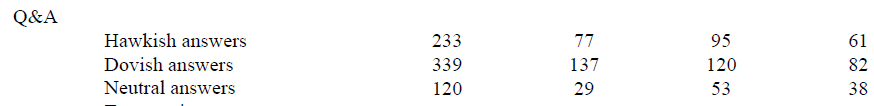

对于Q&A环节相对于原文对鹰派情绪的预测结果比较差

In [45]:
statis_pre(pred_remarks)

president,Overall,Bernanke,Yellen,Powell
sent,,,,
Dovish,271,98,116,57
Hawkish,72,19,41,12
Neutral,103,36,46,21


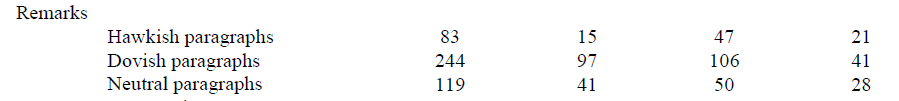


In [46]:
statis_pre(pred_statement)

president,Overall,Bernanke,Yellen,Powell
sent,,,,
Dovish,163,77,74,12
Hawkish,45,16,24,5
Neutral,116,26,67,23


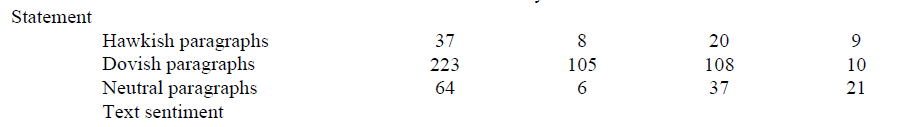

1. 耶伦和伯南克时期的货币政策比鲍威尔在任时期更加的温和（鸽派），这也反映了鲍威尔时期利率增加占主导的政策模式
2. 总体来说，情绪比较偏向鸽派

In [47]:
(pre_day.get(["sent_an","sent_re","sent_st"])).corr()

,sent_an,sent_re,sent_st
sent_an,1.000000,0.002536,0.237875
sent_re,0.002536,1.000000,0.260145
sent_st,0.237875,0.260145,1.000000


文本情绪之间有正相关性，其中文本和演讲/评论部分的相关性比较大，有0.26；Q&A环节回答和声明的相关性次之，有0.23；而问答和演讲环节的相关性比较低